# Summary of PySINDy lecture videos

This notebook is a summary of the PySINDy YouTube lectures found here. In particular, it shows how to use the SINDy method in practice, addressing the following practical questions:
1. #### How does one choose the thresholding parameter $\lambda$?
2. #### How to make SINDy more robust? <br>
    a) Smoothing and more robust derivatives <br>
    b) More data through multiple trajectories <br>
    c) Physical priors with model constraints <br>
    d) Provably stable models with Trapping SINDy <br>
    e) Ensemble methods <br>
    f) Weak-formulation SINDy <br>
3. #### How to handle equations beyond systems of ODES? <br>
    a) Implicit ODEs with SINDy-PI <br>
    b) PDEs with PDE-FIND <br>
4. #### How to choose a regularizer and a sparse regression algorithm?
5. #### How to build tailored candidate libraries?

An interactive version of this notebook is available on binder.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.4.3?filepath=examples/1_feature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

from pysindy.utils import lorenz, enzyme
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-15
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-10

In [3]:
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d

# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator='odeint')
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.plot(threshold_scan, mse, 'bo')
    plt.plot(threshold_scan, mse, 'b')
    plt.ylabel(r'Fitting RMSE', fontsize=20)
    plt.xlabel(r'$\lambda$', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.plot(threshold_scan, mse_sim, 'bo')
    plt.plot(threshold_scan, mse_sim, 'b')
    plt.ylabel('Testing trajectory RMSE', fontsize=20)
    plt.xlabel(r'$\lambda$', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
def plot_data_and_derivative(x, dt, deriv):
    feature_name = ['x', 'y', 'z']
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel('t', fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_dot[:, i], label=r'$\dot{' + feature_name[i] + '}$')
        plt.grid(True)
        plt.xlabel('t', fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
        
def plot_ensemble_results(model, mean_ensemble, std_ensemble, 
                          mean_library_ensemble, std_library_ensemble):
    # Plot results
    xticknames = model.get_feature_names()
    for i in range(10):
        xticknames[i] = '$' + xticknames[i] + '$'
    plt.figure(figsize=(18, 4))
    colors = ['b', 'r', 'k']
    plt.subplot(1, 2, 1)
    # plt.title('ensembling', fontsize=22)
    plt.xlabel('Candidate terms', fontsize=22)
    plt.ylabel('Coefficient values', fontsize=22)
    for i in range(3):
        plt.errorbar(range(10), mean_ensemble[i, :], yerr=std_ensemble[i, :], 
                     fmt='o', color=colors[i],
                     label=r'Equation for $\dot{' + feature_names[i] + r'}$')
    ax = plt.gca()
    plt.grid(True)
    ax.set_xticks(range(10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(xticknames, verticalalignment='top')
    plt.subplot(1, 2, 2)
    plt.xlabel('Candidate terms', fontsize=18)
    # plt.title('library ensembling', fontsize=18)
    for i in range(3):
        plt.errorbar(range(10), mean_library_ensemble[i, :], yerr=std_library_ensemble[i, :], 
                     fmt='o', color=colors[i], 
                     label=r'Equation for $\dot{' + feature_names[i] + r'}$')
    ax = plt.gca()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16, loc='upper right')
    ax.set_xticks(range(10))
    ax.set_xticklabels(xticknames, verticalalignment='top')


# Convert u_dot into a weak form using the pre-defined ode_lib
def convert_u_dot_0D(u, t, ode_lib):  # For weak form ODES
    K = ode_lib.K
    num_pts_per_domain = ode_lib.num_pts_per_domain
    u_dot_integral = np.zeros((K, u.shape[-1]))
    for j in range(u.shape[-1]):
        u_interp = interp1d(t, u[:, j], kind='cubic')
        for k in range(K):
            # Interpolate u onto the kth subdomain
            u_new = u_interp(ode_lib.tgrid_k[k, :])
            # Get the smooth weights on the kth subdomain
            w_diff = ode_lib._smooth_ppoly(
                        [],
                        ode_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    u_new * w_diff, 
                    x=ode_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral

def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1)*(r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))    
    
    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
            q = q + 1
    for i in range(r):
         for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                constraint_matrix[q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)] = 1.0
                q = q + 1
                
    return constraint_zeros, constraint_matrix

# Use optimal m, and calculate eigenvalues(PW) to see if identified model is stable
def check_stability(r, Xi, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print('optimal m: ', opt_m)
    print('As eigvals: ', np.sort(eigvals))
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    print('Estimate of trapping region size, Rm = ', Rm)
    

# define the testing and training Lorenz data we will use for these examples
dt = .002

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
t_train_span = (t_train[0], t_train[-1])
x_train = solve_ivp(lorenz, t_train_span, x0_train, t_eval=t_train, **integrator_keywords).y.T

t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([8, 7, 15])
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T

## Lorenz system
We will fit a SINDy model to the famous Lorenz system:
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z, $$
with $\sigma = 10$, $\rho = 28$, and $\beta = 8/3$.

# Part 1: How to choose algorithm hyperparameters?

In [4]:
# Instantiate and fit the SINDy model
feature_names = ['x', 'y', 'z']
sparse_regression_optimizer = ps.STLSQ(threshold=0)  # default is lambda = 0.1
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -0.001 1 + -10.005 x + 10.003 y
(y)' = -0.016 1 + 27.991 x + -0.998 y + 0.002 z + -1.000 x z
(z)' = 0.009 1 + 0.006 x + -0.004 y + -2.666 z + 0.001 x^2 + 0.999 x y


In [5]:
sparse_regression_optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.999 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


In [6]:
sparse_regression_optimizer = ps.STLSQ(threshold=1.0)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt)
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = -2.793 x
(z)' = 0.000


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/stlsq.py:176: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  "coefficients".format(self.threshold)


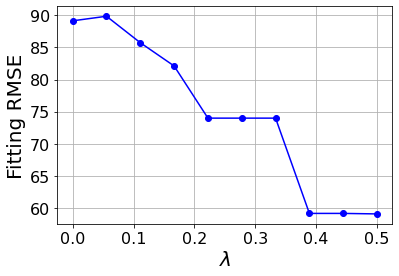

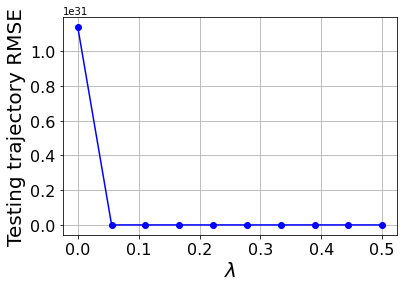

In [7]:
threshold_scan = np.linspace(0, 0.5, 10)
coefs = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)
for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.STLSQ(threshold=threshold)
    model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
    model.fit(x_train_added_noise, t=dt, quiet=True)
    coefs.append(model.coefficients())
    
plot_pareto(coefs, sparse_regression_optimizer, model, threshold_scan, x_test, t_test)

# Part 2: How to make SINDy more robust?

### Part 2a: Differentiate the data with method other than finite differences!
First, let's look at what's wrong with finite differences

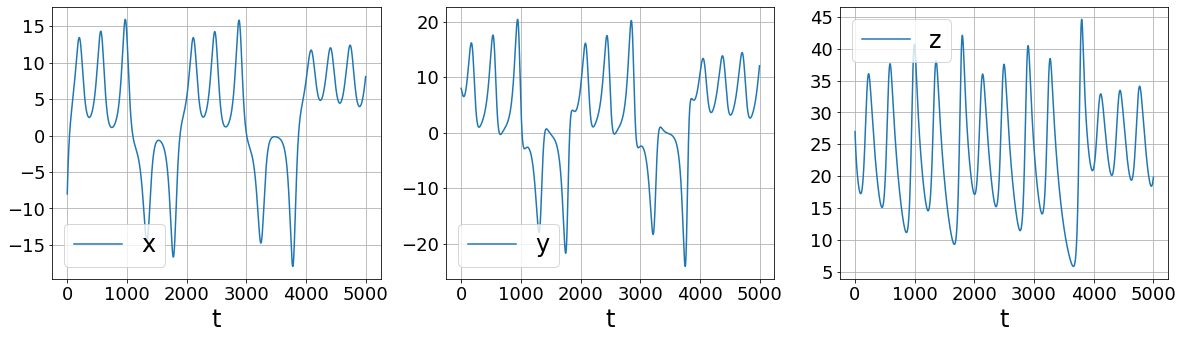

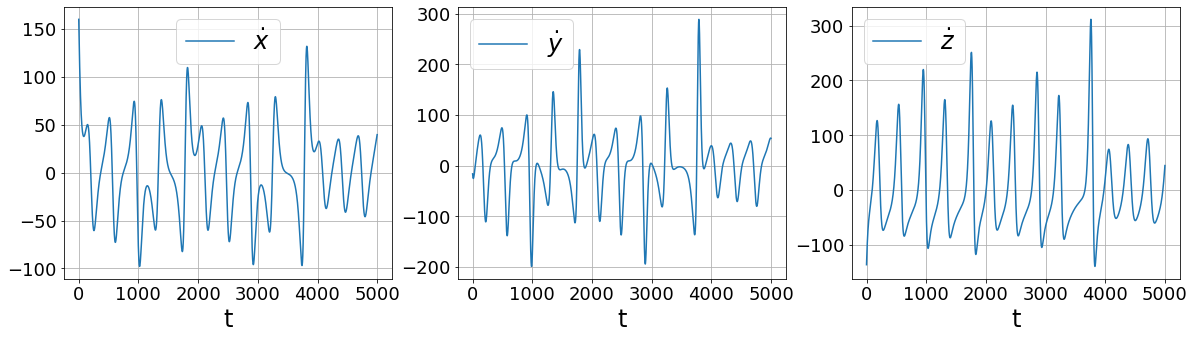

In [8]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train 
plot_data_and_derivative(x_train_added_noise, dt, ps.FiniteDifference()._differentiate)

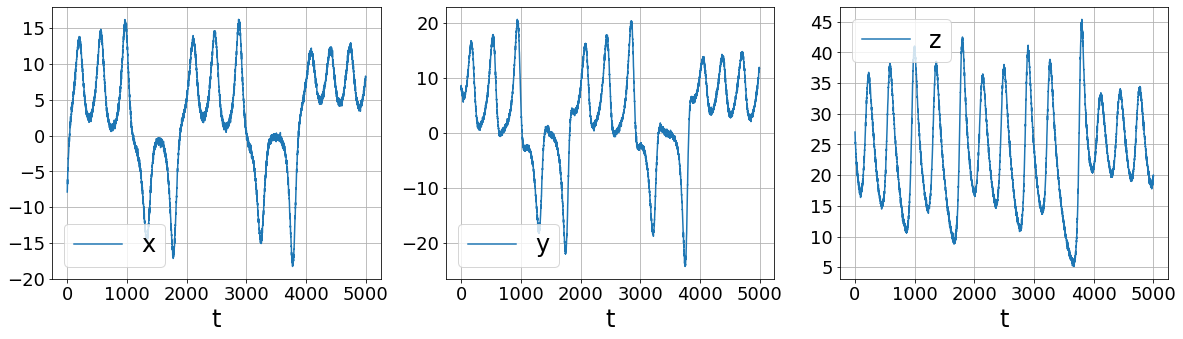

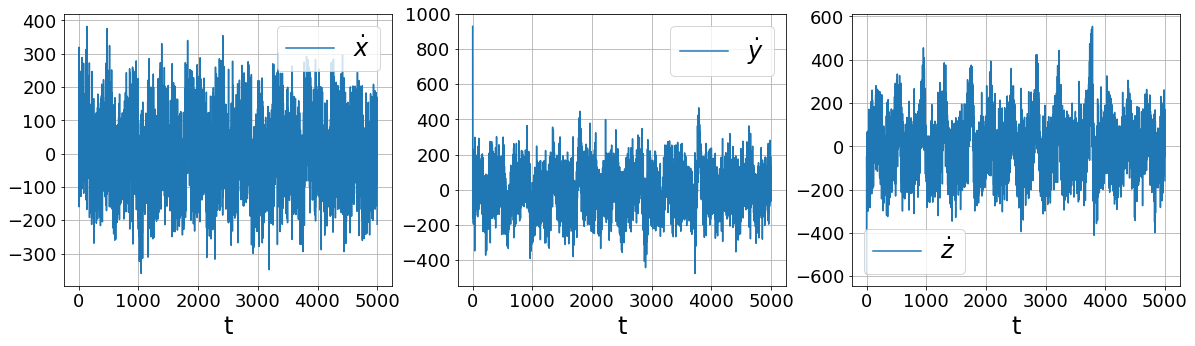

In [9]:
# 2% added noise
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 50.0,  x_train.shape)
plot_data_and_derivative(x_train_added_noise, dt, ps.FiniteDifference()._differentiate)

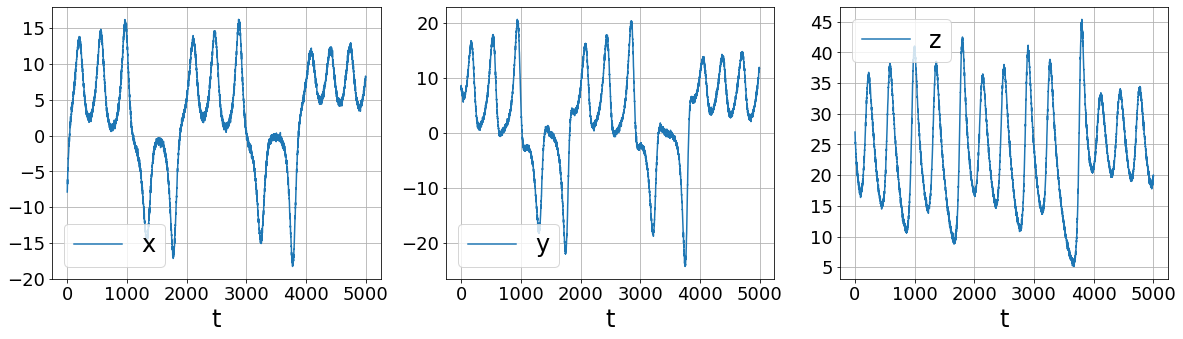

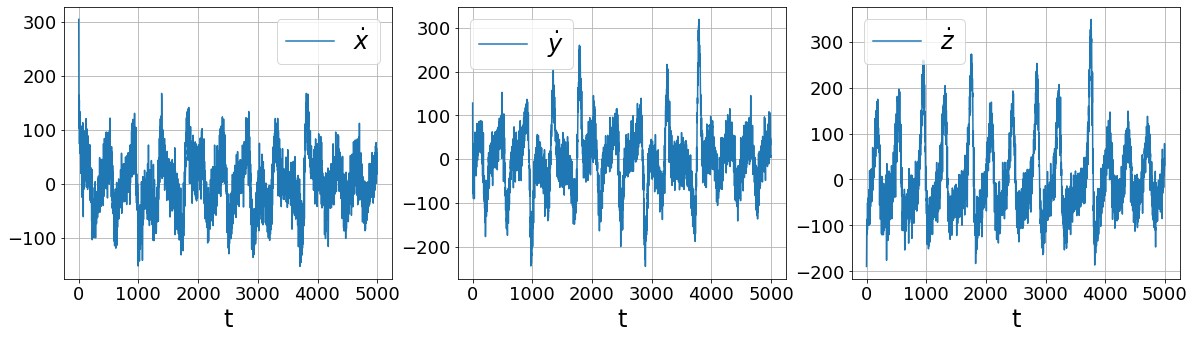

In [10]:
# Repeat but with smoothed finite differences!
plot_data_and_derivative(x_train_added_noise, dt, ps.SmoothedFiniteDifference()._differentiate)

### Part 2b: Simply add more data!

In [11]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 50.0,  x_train.shape)
sparse_regression_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
model.print()

(x)' = -9.970 x + 9.959 y
(y)' = 0.191 1 + 27.676 x + -0.860 y + -0.994 x z
(z)' = 0.236 1 + -2.663 z + 0.997 x y


In [12]:
n_trajectories = 40
x0s = (np.random.rand(n_trajectories, 3) - 0.5) * 20
x_train_multi = []
for i in range(n_trajectories):
    x_train_temp = solve_ivp(lorenz, t_train_span, x0s[i], 
                             t_eval=t_train, **integrator_keywords).y.T
    rmse = mean_squared_error(x_train_temp, np.zeros(x_train_temp.shape), squared=False)
    x_train_multi.append(x_train_temp + np.random.normal(0, rmse / 50.0,  x_train_temp.shape))

sparse_regression_optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

(x)' = -9.858 x + 9.870 y
(y)' = 27.706 x + -0.906 y + -0.993 x z
(z)' = -2.659 z + 0.997 x y


### Part 2c: Use ensemble methods

In [13]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 20.0,  x_train.shape)
sparse_regression_optimizer = ps.STLSQ(threshold=0.5)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
model.print()

(x)' = -9.484 x + 9.585 y
(y)' = 26.385 x + -0.540 y + -0.962 x z
(z)' = -0.742 1 + -2.635 z + 0.995 x y


In [14]:
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt, ensemble=True, quiet=True)
ensemble_coefs = model.coef_list
mean_ensemble = np.mean(ensemble_coefs, axis=0)
std_ensemble = np.std(ensemble_coefs, axis=0)

In [15]:
# Now we sub-sample the library. The default is to omit a single library term.
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train, t=dt, library_ensemble=True, quiet=True)
library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

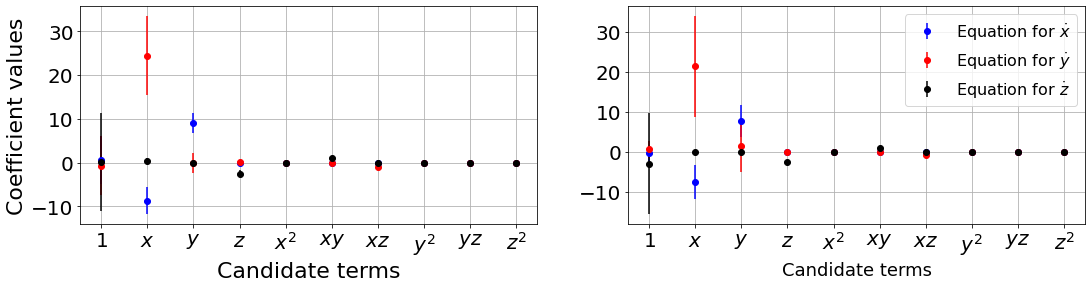

In [16]:
plot_ensemble_results(model, mean_ensemble, std_ensemble, 
                      mean_library_ensemble, std_library_ensemble)

### Part 2d: use prior physical knowledge to constrain the model

In [17]:
# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit(x_train)
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=constraint_lhs)
model = ps.SINDy(optimizer=optimizer, feature_library=library).fit(x_train, t=dt)
model.print()

Features (10): ['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']
(x0)' = -10.002 x0 + 10.002 x1
(x1)' = 28.000 x0 + -1.003 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 0.999 x0 x1


### Part 2e (advanced): use trapping SINDy for globally stable models

In [18]:
# define hyperparameters
threshold = 0
max_iter = 10000
eta = 1.0e-2
constraint_zeros, constraint_matrix = make_constraints(3)

# run trapping SINDy
sindy_opt = ps.TrappingSR3(threshold=threshold, eta=eta, gamma=-1, max_iter=max_iter,
                           constraint_lhs=constraint_matrix,
                           constraint_rhs=constraint_zeros,
                           constraint_order="feature"
                           )

# Initialize quadratic SINDy library, with custom ordering to be consistent with the constraint
library_functions = [lambda x:x, lambda x, y:x * y, lambda x:x ** 2]
library_function_names = [lambda x:x, lambda x, y:x + y, lambda x:x + x]
sindy_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=dt, quiet=True)
model.print()

Xi = model.coefficients().T
check_stability(3, Xi, sindy_opt)

 Iteration | Data Error | Stability Error |   L1 Error
           0  1.77807e+03  1.27912e+04  0.00000e+00
        1000  9.13370e+02  2.64720e+02  0.00000e+00
        2000  1.12364e+03  3.53801e+01  0.00000e+00
        3000  1.18388e+03  1.12070e+01  0.00000e+00
        4000  1.20560e+03  5.13168e+00  0.00000e+00
        5000  1.21362e+03  2.84954e+00  0.00000e+00
        6000  1.21575e+03  1.77788e+00  0.00000e+00
        7000  1.21505e+03  1.19860e+00  0.00000e+00
        8000  1.21294e+03  8.53752e-01  0.00000e+00
        9000  1.21008e+03  6.33562e-01  0.00000e+00
(x0)' = -9.506 x0 + 9.725 x1 + -0.050 x2 + -0.020 x0x1 + -0.013 x0x2 + 0.007 x1x2 + 0.014 x1x1 + 0.002 x2x2
(x1)' = 27.311 x0 + -0.568 x1 + 0.055 x2 + -0.014 x0x1 + -0.981 x0x2 + -0.012 x1x2 + 0.020 x0x0 + -0.002 x2x2
(x2)' = 0.076 x0 + -0.074 x1 + -2.677 x2 + 0.974 x0x1 + -0.002 x0x2 + 0.002 x1x2 + 0.013 x0x0 + 0.012 x1x1
optimal m:  [-0.86662329 -0.08912209 36.05521361]
As eigvals:  [-10.05969455  -2.67699398  -0.901482

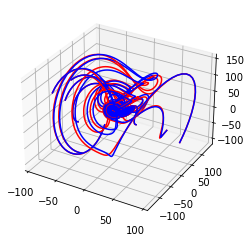

In [19]:
# show that new model trajectories are all stable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(10):
    x0_new = (np.random.rand(3) - 0.5) * 200
    x_test_new = solve_ivp(lorenz, t_test_span, x0_new, t_eval=t_test, **integrator_keywords).y.T
    ax.plot(x_test_new[:, 0], x_test_new[:, 1], x_test_new[:, 2], 'r')
    x_test_pred_new = model.simulate(x0_new, t=t_test, integrator="odeint")
    plt.plot(x_test_pred_new[:, 0], x_test_pred_new[:, 1], x_test_pred_new[:, 2], 'b')

### Part 2f (advanced): use the weak formulation of SINDy

Normal SINDy result on 10% Lorenz noise: 
(x)' = 42.384 1 + -2.381 x + 7.011 y + -2.862 z + 0.218 x^2 + 0.311 x y + -0.131 x z + -0.232 y^2
(y)' = 9.541 1 + -0.573 x + 13.808 y + 0.551 z + -0.358 x^2 + 0.959 x y + -0.295 x z + -0.530 y^2 + -0.272 y z
(z)' = 33.130 1 + -16.031 x + 8.859 y + -3.401 z + 0.306 x^2 + 0.344 x y + 0.446 x z + 0.134 y^2 + -0.274 y z
Weak form result on 10% Lorenz noise: 
(x)' = 0.126 1 + -9.908 x + 9.930 y
(y)' = -0.287 1 + 27.886 x + -0.924 y + -1.001 xz
(z)' = -0.744 1 + -0.172 x + -2.580 z + 0.983 xy


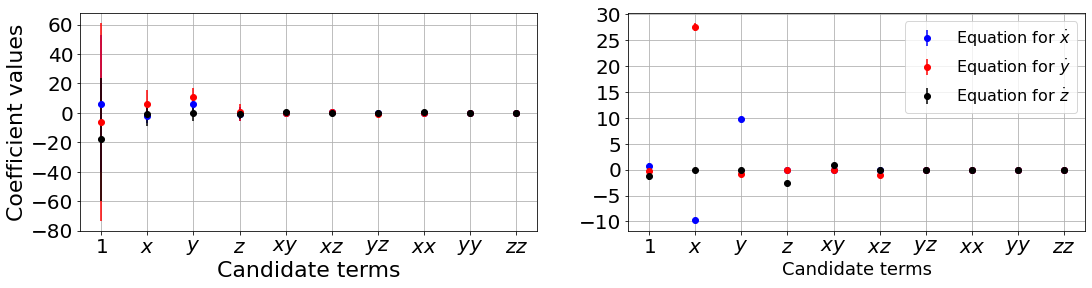

In [20]:
ode_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    temporal_grid=t_train,
    include_bias=True,
    weak_form=True,
)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 10.0,  x_train.shape)

x_dot_train_integral = convert_u_dot_0D(x_train_added_noise, t_train, ode_lib)

# Fit a normal SINDy model
optimizer = ps.STLSQ()
model = ps.SINDy(feature_names=feature_names, optimizer=optimizer)
model.fit(x_train_added_noise, t=dt, ensemble=True)
print('Normal SINDy result on 10% Lorenz noise: ')
model.print()
regular_models = model.coef_list
regular_mean = np.mean(regular_models, axis=0)
regular_std = np.std(regular_models, axis=0)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.STLSQ()
model = ps.SINDy(feature_library=ode_lib, 
                 feature_names=feature_names,
                 optimizer=optimizer)
model.fit(x_train_added_noise, x_dot=x_dot_train_integral, ensemble=True)
print('Weak form result on 10% Lorenz noise: ')
model.print()
weak_form_models = model.coef_list
weak_form_mean = np.mean(weak_form_models, axis=0)
weak_form_std = np.std(weak_form_models, axis=0)

plot_ensemble_results(model, regular_mean, regular_std, 
                      weak_form_mean, weak_form_std)

# Part 3a: Implicit ODEs

## Implicit ODEs 
How would we use SINDy to solve an implicit ODE? In other words, now the LHS can depend on x and x_dot, 
$$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}})$$


In order to deal with this, we need a library $\Theta(\mathbf{x}, \dot{\mathbf{x}})$. SINDy parallel implicit (SINDy-PI) is geared to solve these problems. It solves the optimization problem,
$$argmin_\mathbf{\Xi} (\|\Theta(\mathbf{X}, \dot{\mathbf{X}}) - \Theta(\mathbf{X}, \dot{\mathbf{X}})\mathbf{\Xi}\| + \lambda \|\mathbf{\Xi}\|_1)$$
such that diag$(\mathbf{\Xi}) = 0$. So for every candidate library term it generates a different model. With N state variables, we need to choose N of the equations to solve for the system evolution. See the [SINDy-PI notebook](https://github.com/dynamicslab/pysindy/blob/master/examples/9_sindypi_with_sympy.ipynb) for more details. 

Here we illustrate successful identification of the 1D Michelson-Menten enzyme model
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Or, equivalently
$$\dot{x} = 0.6 - 3 x - \frac{10}{3} x\dot{x}.$$

Note that some of the model fits fail. This is usually because the LHS term being fitted is a poor match to the data, but this error can also be caused by CVXPY not liking the parameters passed to the solver.


In [23]:
# define parameters
r = 1
dt = 0.001
T = 4
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t, **integrator_keywords).y.T

# Initialize custom SINDy library so that we can have x_dot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both the x_library_functions and x_dot_library_functions names
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: x,
]

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t[1:-1],
    function_names=library_function_names,
    include_bias=True,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
# Note that if LHS of the equation fits the data poorly,
# CVXPY often returns failure.
sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    thresholder="l1",
    max_iter=20000,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

Solver failed on model  3 , setting coefs to zeros
1 = 5.000 x0 + 1.667 x0_dot + 5.556 x0x0_dot
x0 = 0.200 1 + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.007 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001 1 + 0.363 x0x0x0 + 0.041 x0x0_dot + -1.205 x0x0x0x0x0_dot
x0_dot = 0.600 1 + -3.000 x0 + -3.333 x0x0_dot
x0x0_dot = 0.180 1 + -0.900 x0 + -0.300 x0_dot
x0x0x0_dot = -0.004 1 + 0.136 x0 + -0.507 x0x0 + -0.344 x0x0x0 + -0.102 x0x0_dot + -0.219 x0x0x0x0x0_dot
x0x0x0x0_dot = 0.003 1 + 0.001 x0 + -0.391 x0x0x0 + -0.247 x0x0x0x0 + -0.108 x0x0_dot
x0x0x0x0x0_dot = 0.001 1 + -0.670 x0x0x0x0 + -0.005 x0_dot + 0.029 x0x0_dot + -0.271 x0x0x0_dot


# Part 3b: Partial differential equations (PDEs)

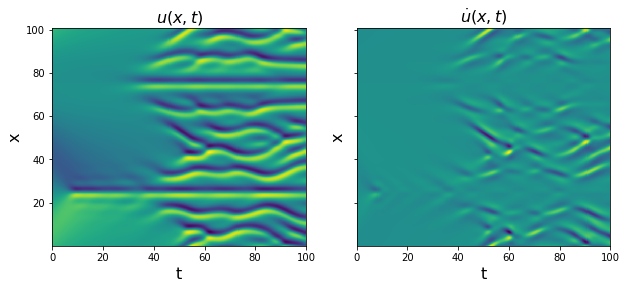

In [26]:
from scipy.io import loadmat

# Load data from .mat file
data = loadmat('data/kuramoto_sivishinky.mat')
t = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
u_shaped = np.reshape(u, (len(x), len(t), 1))
u_dot = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(t, x, u_dot[:, :, 0])
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [28]:
train = range(0, int(len(t) * 0.6))
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
u_dot_train = u_dot[:, train]
u_dot_test = u_dot[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_dot_train_flattened = np.reshape(u_dot_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))
u_dot_test_flattened = np.reshape(u_dot_test, (len(x) * len(t_test), 1))

# Define PDE library that is quadratic in u, and fourth-order in spatial derivatives of u.
# Also, include a constant term (include_bias=True).
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
)

# Again, loop through all the optimizers
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=10, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, feature_names=['x'], optimizer=optimizer)
model.fit(u_train_flattened, x_dot=u_dot_train_flattened)
model.print()
u_dot_stlsq = model.predict(u_test_flattened)


STLSQ model: 
(x)' = -0.992 x_11 + -0.997 x_1111 + -0.983 xx_1


# Part 4: How to choose a regularizer and a sparse regression algorithm?
![title](optimizer_summary.jpg)


# Part 5: How to build complex candidate libraries

### Concatenate two libraries
Two or more libraries can be combined via the `+` operator.

In [22]:
identity_library = ps.IdentityLibrary()
fourier_library = ps.FourierLibrary()
combined_library = identity_library + fourier_library

model = ps.SINDy(feature_library=combined_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.get_feature_names()

ValueError: input features list is not the right length

### Tensor two libraries together
Two or more libraries can be tensored together via the `*` operator.

In [ ]:
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()
combined_library = poly_library * fourier_library

model = ps.SINDy(feature_library=combined_library, feature_names=feature_names)
model.fit(x_train, t=dt)
model.get_feature_names()

### Generalized library

Create the most general and flexible possible library by combining and tensoring as many libraries as you want, and you can even specify which input variables to use to generate each library! 
One can specify:
<br>
1. N different libraries to add together
2. A list of inputs to use for each library. For two libraries with four inputs this would look like inputs_per_library = [[0, 1, 2, 3], [0, 1, 2, 3]] and to avoid using the first two input variables in the second library, you would change it to something like inputs_per_library = [[0, 1, 2, 3], [2, 2, 2, 3]], since duplicates are thrown out and [2, 2, 2, 3] will reduce to [2, 3]. 
        
3. A list of libraries to tensor together and add to the overall library. For four libraries, we could make three tensor libraries by using tensor_array = [[1, 0, 1, 1], [1, 1, 1, 1], [0, 0, 1, 1]]. The first sub-array takes the tensor product of libraries 0, 2, 3, the second takes the tensor product of all of them, and the last takes the tensor product of the libraries 2 and 3. This is a silly example since the [1, 1, 1, 1] tensor product already contains all the possible terms. <br>
<br>
Note that using this is a more advanced feature, but with the benefit that it allows any SINDy library you want. <br>

In [ ]:
from scipy.io import loadmat

# Load data
data = loadmat("data/burgers.mat")
t = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = t[1] - t[0]
dx = x[1] - x[0]

# Plot the spatiotemporal data
plt.figure()
plt.imshow(u, aspect="auto")
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
u_dot = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    u_dot[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(u_dot[:, :, 0], aspect="auto")

u_flattened = np.reshape(u, (len(x) * len(t), 1))
u_dot_flattened = np.reshape(u_dot, (len(x) * len(t), 1))

# Define quadratic library with up to third order derivatives on a uniform spatial grid
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Note that u and u_dot are flattened, and u_dot must be passed to model.fit
model.fit(u_flattened, x_dot=u_dot_flattened)
model.print()